<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/06-common-design-building-blocks/03_skip_connections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Skip connections

We will discuss five new methods that work for feed-forward models and
one new improvement to RNNs. We introduce the first five methods roughly in the
order that they were invented, as each tends to use the preceding techniques in their
design. 

Individually, they improve accuracy and speed up training; but combined, they
are greater than the sum of their parts.

1. Better activation function
2. Batch/Layer normalization
3. Skip connections and 1 x 1 convolution
4. Residual connections
5. Long short-term memory (LSTM) layer

##Setup

In [ ]:
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.metrics import accuracy_score

import time

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from idlmam import train_network, Flatten, weight_reset, set_seed
from idlmam import LanguageNameDataset, pad_and_pack, EmbeddingPackable, LastTimeStep, LambdaLayer

In [4]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Dataset

We use the
Fashion-MNIST dataset because it is slightly more challenging while retaining the same
size and shape as the original MNIST corpus, which will let us accomplish some testing
in a reasonable time.

In [ ]:
B = 128

train_data = torchvision.datasets.FashionMNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST("./data", train=True, transform=transforms.ToTensor(), download=True)

training_loader = DataLoader(train_data, batch_size=B, shuffle=True)
testing_loader = DataLoader(test_data, batch_size=B)

##Baseline model

Let’s define some basic hyperparameters.

In [7]:
W, H = 28, 28
D = 28 * 28       # input size
n = 188           # Hidden layer size
C= 1              # How many channels are in the input?
n_filters = 32    # filters per convolutional layer
classes = 10      # How many classes are there?

In [8]:
fc_model = nn.Sequential(
  nn.Flatten(),
  nn.Linear(D,  n), 
  nn.Tanh(), #First hidden layer 
  #Now that each remaining layer has the same input/output sizes, we can make them with a list unpacking
  *[nn.Sequential(nn.Linear(n,  n), nn.Tanh()) for _ in range(5)], 
  nn.Linear(n, classes),
)

In [9]:
cnn_model = nn.Sequential(
  nn.Conv2d(C, n_filters, 3, padding=1),             
  nn.Tanh(),
  nn.Conv2d(n_filters, n_filters, 3, padding=1),     
  nn.Tanh(),
  nn.Conv2d(n_filters, n_filters, 3, padding=1),     
  nn.Tanh(),
  nn.MaxPool2d((2,2)),
  
  nn.Conv2d(  n_filters, 2*n_filters, 3, padding=1), 
  nn.Tanh(),
  nn.Conv2d(2*n_filters, 2*n_filters, 3, padding=1), 
  nn.Tanh(),
  nn.Conv2d(2*n_filters, 2*n_filters, 3, padding=1), 
  nn.Tanh(),
  nn.MaxPool2d((2,2)),

  nn.Conv2d(2*n_filters, 4*n_filters, 3, padding=1), 
  nn.Tanh(),
  nn.Conv2d(4*n_filters, 4*n_filters, 3, padding=1), 
  nn.Tanh(),

  nn.Flatten(),
  nn.Linear(D*n_filters//4, classes),
)

We use our new train_network function to train all of the models.

In [ ]:
loss_func = nn.CrossEntropyLoss()

fc_results = train_network(fc_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)

In [ ]:
cnn_results = train_network(cnn_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)

In [12]:
fc_results.head()

,epoch,total time,train loss,test loss,train Acc,test Acc
0,0,16.723873,0.633577,0.461121,0.766650,0.837750
1,1,23.407999,0.434101,0.413325,0.845150,0.849067
2,2,32.850896,0.391224,0.358891,0.857450,0.867400
3,3,41.744655,0.363648,0.327916,0.868283,0.877617
4,4,48.521727,0.346689,0.332774,0.873750,0.883317


In [13]:
cnn_results.head()

,epoch,total time,train loss,test loss,train Acc,test Acc
0,0,19.592823,0.491520,0.315718,0.82165,0.885933
1,1,35.176159,0.320271,0.300401,0.88580,0.892483
2,2,49.085885,0.283402,0.227856,0.90060,0.918867
3,3,61.924005,0.256085,0.238842,0.90905,0.912200
4,4,75.079752,0.246041,0.245748,0.91435,0.917450


Let’s be explicit and tell Python we are finished so we can get back the GPU memory.

In [14]:
del fc_model
del cnn_model

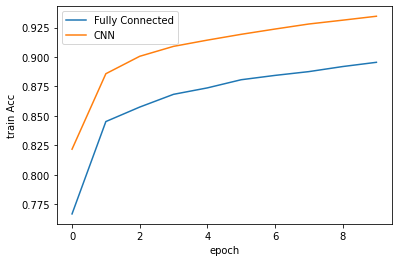

In [15]:
sns.lineplot(x="epoch", y="train Acc", data=fc_results, label="Fully Connected")
sns.lineplot(x="epoch", y="train Acc", data=cnn_results, label="CNN")

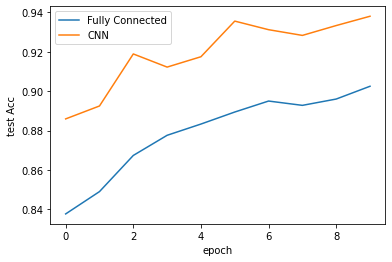

In [16]:
sns.lineplot(x="epoch", y="test Acc", data=fc_results, label="Fully Connected")
sns.lineplot(x="epoch", y="test Acc", data=cnn_results, label="CNN")

##ReLU Baseline

In [17]:
# How much I want the LeakyReLU to "leak" by. Anything in [0.01, 0.3] would have been fine.
leak_rate = 0.1

fc_relu_model = nn.Sequential(
  nn.Flatten(),
  nn.Linear(D,  n), 
  nn.LeakyReLU(leak_rate), 
  #Now that each remaining layer has the same input/output sizes, we can make them with a list unpacking
  *[nn.Sequential(nn.Linear(n,  n), nn.LeakyReLU(leak_rate)) for _ in range(5)], 
  nn.Linear(n, classes),
)

In [18]:
def cnn_layer(in_filters, out_filters=None, kernel_size=3):
  """
  in_filters: how many channels are coming into the layer
  out_filters: how many channels this layer should learn / output, or `None` if we want to have the same number of channels as the input.
  kernel_size: how large the kernel should be
  """
  if out_filters is None:
    # This is a common pattern, so lets automate it as a default if not asked
    out_filters = in_filters 
  # padding to stay the same size
  padding = kernel_size // 2
  # Combine the layer and activation into a single unit
  return nn.Sequential(
    nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding),
    nn.LeakyReLU(leak_rate)
  )

In [19]:
cnn_relu_model = nn.Sequential(
  cnn_layer(C, n_filters),
  cnn_layer(n_filters),
  cnn_layer(n_filters),
  nn.MaxPool2d((2,2)),
  
  cnn_layer(n_filters, 2 * n_filters),
  cnn_layer(2 * n_filters),
  cnn_layer(2 * n_filters),
  nn.MaxPool2d((2,2)),

  cnn_layer(2 * n_filters, 4 * n_filters),
  cnn_layer(4 * n_filters),

  nn.Flatten(),
  nn.Linear(D*n_filters//4, classes),
)

In [ ]:
fc_relu_results = train_network(fc_relu_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del fc_relu_model

In [ ]:
cnn_relu_results = train_network(cnn_relu_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del cnn_relu_model

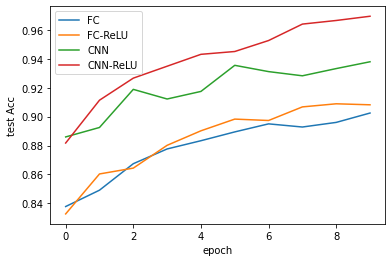

In [22]:
sns.lineplot(x="epoch", y="test Acc", data=fc_results, label="FC")
sns.lineplot(x="epoch", y="test Acc", data=fc_relu_results, label="FC-ReLU")
sns.lineplot(x="epoch", y="test Acc", data=cnn_results, label="CNN")
sns.lineplot(x="epoch", y="test Acc", data=cnn_relu_results, label="CNN-ReLU")

##Batch Normalization Baseline

In [23]:
fc_bn_model = nn.Sequential(
  nn.Flatten(),
  nn.Linear(D, n), 
  nn.BatchNorm1d(n),
  nn.LeakyReLU(leak_rate), 
  #Now that each remaining layer has the same input/output sizes, we can make them with a list unpacking
  *[nn.Sequential(nn.Linear(n, n), nn.BatchNorm1d(n), nn.LeakyReLU(leak_rate)) for _ in range(5)], 
  nn.Linear(n, classes),
)

In [24]:
def cnn_layer(in_filters, out_filters=None, kernel_size=3):
  """
  in_filters: how many channels are coming into the layer
  out_filters: how many channels this layer should learn / output, or `None` if we want to have the same number of channels as the input.
  kernel_size: how large the kernel should be
  """
  if out_filters is None:
    # This is a common pattern, so lets automate it as a default if not asked
    out_filters = in_filters 
  # padding to stay the same size
  padding = kernel_size // 2
  # Combine the layer and activation into a single unit
  return nn.Sequential(
    nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding),
    nn.BatchNorm2d(out_filters),  # The only change: adding BatchNorm2d after our convolution
    nn.LeakyReLU(leak_rate)
  )

In [25]:
cnn_bn_model = nn.Sequential(
  cnn_layer(C, n_filters),
  cnn_layer(n_filters),
  cnn_layer(n_filters),
  nn.MaxPool2d((2,2)),
  
  cnn_layer(n_filters, 2 * n_filters),
  cnn_layer(2 * n_filters),
  cnn_layer(2 * n_filters),
  nn.MaxPool2d((2,2)),

  cnn_layer(2 * n_filters, 4 * n_filters),
  cnn_layer(4 * n_filters),

  nn.Flatten(),
  nn.Linear(D*n_filters//4, classes),
)

We are ready to train both models.

In [ ]:
fc_bn_results = train_network(fc_bn_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del fc_bn_model

In [ ]:
cnn_bn_results = train_network(cnn_bn_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del cnn_bn_model

Let’s compare it with baseline model.

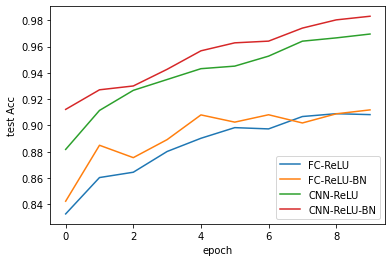

In [28]:
sns.lineplot(x="epoch", y="test Acc", data=fc_relu_results, label="FC-ReLU")
sns.lineplot(x="epoch", y="test Acc", data=fc_bn_results, label="FC-ReLU-BN")
sns.lineplot(x="epoch", y="test Acc", data=cnn_relu_results, label="CNN-ReLU")
sns.lineplot(x="epoch", y="test Acc", data=cnn_bn_results, label="CNN-ReLU-BN")

##Skip connections

With a normal feed-forward network, an output from one layer
goes directly to the next layer. 

With skip connections, this is still true, but we also “skip”
the next layer and connect to a preceding layer as well.

Why use skip connections? 

Part of the intuition is that skip connections can make
the optimization process easier. 

Said another way, skip connections can shrink the gap
between a network’s capacity (what it could represent) and what it can learn (what it learns to represent).

Every hidden layer gets some amount of
information about the gradient directly from the output layer, giving more direct access
to the gradient, and the gradient is also processed from the longer path going layer by
layer. 

This more direct feedback can make learning easier. It can also have benefits for certain applications that require high- and low-level details.

In [29]:
class FullySkipConnection(nn.Module):
  def __init__(self, n_layers, in_size, out_size, leak_rate=0.1):
    """
    n_layers: how many hidden layers for this block of dense skip connections
    in_size: how many features are coming into this layer
    out_size: how many features should be used for the final layer of this block.  
    leak_rate: the parameter for the LeakyReLU activation function.
    """
    super().__init__()

    # The final layer will be treated differently, so lets grab it's index to use in the next two lines
    layer = n_layers - 1
    # The linear and batch norm layers are stored in `layers` and `bns` respectively. A list comprehensive creates all the layers in one line each.
    self.layers = nn.ModuleList([
      nn.Linear(in_size * layer, out_size) 
      if i == layer else nn.Linear(in_size, in_size) 
      for i in range(n_layers)
    ])
    self.batch_norm = nn.ModuleList([
      nn.BatchNorm1d(out_size) 
      if i == layer else nn.BatchNorm1d(in_size) 
      for i in range(n_layers)
    ])
    # Since we are writing our own `forward` function instead of using nn.Sequential, we can just use one activation object multiple time
    self.activation = nn.LeakyReLU(leak_rate)

  def forward(self, x):
    # need a location to store the activations from every layer
    activations = []

    # zip the linear and normalization layers into paired tuples, using [:-1] to select all but the last item in each list
    for layer, batch_norm in zip(self.layers[:-1], self.batch_norm[:-1]):
      x = self.activation(batch_norm(layer(x)))
      activations.append(x)

    # concatenate the activations together, this makes the input for the last layer
    x = torch.cat(activations, dim=1)

    # Now manually use the last linear and batch-norm layer on this concatenated input, giving us the result
    return self.activation(self.batch_norm[-1](self.layers[-1](x)))

A PyTorch module defining a class for creating skip connections. It will create one larger block of multiple layers in a “dense” style skip connection, containing `n_layers` total. 

It is used on its own it can create dense networks, or used sequentially it can create staggered skip connections.

In [30]:
fc_skip_model = nn.Sequential(
  nn.Flatten(),
  FullySkipConnection(2, D, n), 
  FullySkipConnection(2, n, n),
  FullySkipConnection(2, n, n), 
  nn.Linear(n, classes),
)

In [ ]:
fc_skip_results = train_network(fc_skip_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del fc_skip_model

Let's plot only the fully connected networks we have trained so far.

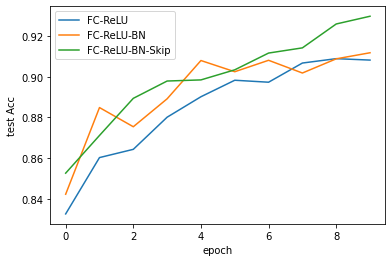

In [32]:
sns.lineplot(x="epoch", y="test Acc", data=fc_relu_results, label="FC-ReLU")
sns.lineplot(x="epoch", y="test Acc", data=fc_bn_results, label="FC-ReLU-BN")
sns.lineplot(x="epoch", y="test Acc", data=fc_skip_results, label="FC-ReLU-BN-Skip")

Part of the issue is that skip connections were
more effective on their own before normalization layers were invented to help tackle the same problem. 

Since our networks both have BN, the skip connections are a little
redundant.

##Convolutional Skip connections

Now, let’s
repeat this exercise for the convolutional network.

In [36]:
class ConvSkipConnection(nn.Module):
  def __init__(self, n_layers, in_channels, out_channels, kernel_size=3, leak_rate=0.1):
    super().__init__()

    # The last convolution will have a different number of inputs and output channels, so we still need that index
    layer = n_layers - 1
    # this is just simple helper values
    f = (kernel_size, kernel_size)
    pad = (kernel_size - 1) // 2

    # The linear and batch norm layers are stored in `layers` and `bns` respectively. A list comprehensive creates all the layers in one line each.
    self.layers = nn.ModuleList([
      nn.Conv2d(in_channels * layer, out_channels, kernel_size=f, padding=pad) 
      if i == layer else nn.Conv2d(in_channels, in_channels, kernel_size=f, padding=pad) 
      for i in range(n_layers)
    ])
    self.batch_norm = nn.ModuleList([
      nn.BatchNorm2d(out_channels) 
      if i == layer else nn.BatchNorm2d(in_channels) 
      for i in range(n_layers)
    ])
    # Since we are writing our own `forward` function instead of using nn.Sequential, we can just use one activation object multiple time
    self.activation = nn.LeakyReLU(leak_rate)

  def forward(self, x):
    # need a location to store the activations from every layer
    activations = []

    # zip the linear and normalization layers into paired tuples, using [:-1] to select all but the last item in each list
    for layer, batch_norm in zip(self.layers[:-1], self.batch_norm[:-1]):
      x = self.activation(batch_norm(layer(x)))
      activations.append(x)

    # concatenate the activations together, this makes the input for the last layer
    x = torch.cat(activations, dim=1)

    # Now manually use the last linear and batch-norm layer on this concatenated input, giving us the result
    return self.activation(self.batch_norm[-1](self.layers[-1](x)))

But there is a significant
problem: our input has only three channels. That’s too few for the network to learn something useful. 

To fix that, we insert a single Conv2d layer at the start with no activation
function. 

This makes it mathematically redundant, but our code is easier to organize
because SkipConv2d starts constructing a larger set of filters.

In [37]:
cnn_skip_model = nn.Sequential(
  nn.Conv2d(C, n_filters, (3, 3), padding=1),
  ConvSkipConnection(3, n_filters, 2 * n_filters),
  nn.MaxPool2d((2,2)),
  nn.LeakyReLU(),
  
  ConvSkipConnection(3, 2 * n_filters, 4 * n_filters),
  nn.MaxPool2d((2,2)),

  ConvSkipConnection(2, 4 * n_filters, 4 * n_filters),

  nn.Flatten(),
  nn.Linear(D*n_filters//4, classes),
)

In [ ]:
cnn_skip_results = train_network(cnn_skip_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del cnn_skip_model

Let’s plot the results with CNN relu, BN, and skip connections based models.

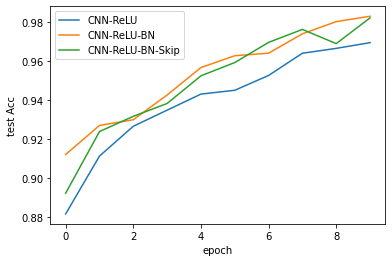

In [39]:
sns.lineplot(x="epoch", y="test Acc", data=cnn_relu_results, label="CNN-ReLU")
sns.lineplot(x="epoch", y="test Acc", data=cnn_bn_results, label="CNN-ReLU-BN")
sns.lineplot(x="epoch", y="test Acc", data=cnn_skip_results, label="CNN-ReLU-BN-Skip")

In practical experience, skip connections can
sometimes make a big difference on their own, but it’s very problem-dependent. 

So why are we learning about them? 

Combined with one more trick, skip connections form
one of the basic building blocks of a more powerful and routinely successful technique
called a **residual layer** that is reliably more effective.

